In [2]:
import csv
import numpy as np
import pandas as pd

def td_dat_file_generation(time_series, cluster_matrix, nbr_td, out_path):
    """Generate the .dat file for the typical days"""
    eud_params = {'Electricity (%_elec)': 'param electricity_time_series :',
                    'Space Heating (%_sh)': 'param heating_time_series :',
                    'Passanger mobility (%_pass)': 'param mob_pass_time_series :',
                    'Freight mobility (%_freight)': 'param mob_freight_time_series :'}
    # for resources timeseries that have only 1 tech linked to it
    res_params = {'PV': 'PV', 'Wind_onshore': 'WIND_ONSHORE', 'Wind_offshore': 'WIND_OFFSHORE',
                    'Hydro_river': 'HYDRO_RIVER',
                    }
    # for resources timeseries that have several techs linked to it
    res_mult_params = {'Solar': ['DHN_SOLAR', 'DEC_SOLAR']}

    # Redefine the output file from the out_path given #
    out_path ='tutorial_output/'+'ESTD_' + str(nbr_td) + 'TD.dat'

    # READING OUTPUT OF STEP1 #
    td_data = generate_t_h_td(cluster_matrix.reset_index(drop=True).rename(columns={'TypicalDay': 'TD_of_days'}), nbr_td)
    # config['td_data'] = td_data

    # COMPUTING NUMBER OF DAYS REPRESENTED BY EACH TD #
    sorted_td = td_data['td_count'].copy()

    # BUILDING T_H_TD MATRICE #
    # generate T_H_TD
    t_h_td = td_data['t_h_td'].copy()
    # giving the right syntax for AMPL
    t_h_td['par_g'] = '('
    t_h_td['par_d'] = ')'
    t_h_td['comma1'] = ','
    t_h_td['comma2'] = ','
    # giving the right order to the columns
    t_h_td = t_h_td[['par_g', 'H_of_Y', 'comma1', 'H_of_D', 'comma2', 'TD_number', 'par_d']]

    # COMPUTING THE NORM OVER THE YEAR ##
    norm = time_series.sum(axis=0)
    norm.index.rename('Category', inplace=True)
    norm.name = 'Norm'

    # BUILDING TD TIMESERIES #
    # creating df with 2 columns : day of the year | hour in the day
    d_of_h = np.repeat(np.arange(1, 366, 1), 24, axis=0)  # 24 times each day of the year
    h_of_d = np.resize(np.arange(1, 25), 24 * 365)  # 365 times hours from 1 to 24
    day_and_hour = pd.DataFrame(np.vstack((d_of_h, h_of_d)).T, index=np.arange(1, 8761, 1),
                                columns=['D_of_H', 'H_of_D'])
    day_and_hour = day_and_hour.astype('int64')
    time_series = time_series.merge(day_and_hour, left_index=True, right_index=True)

    # selecting time series of TD only
    td_ts = time_series[time_series['D_of_H'].isin(sorted_td['TD_of_days'])]

    # COMPUTING THE NORM_TD OVER THE YEAR FOR CORRECTION #
    # computing the sum of ts over each TD
    agg_td_ts = td_ts.groupby('D_of_H').sum()
    agg_td_ts.reset_index(inplace=True)
    agg_td_ts.drop(columns=['D_of_H', 'H_of_D'], inplace=True)
    # multiplicating each TD by the number of day it represents
    for c in agg_td_ts.columns:
        agg_td_ts[c] = agg_td_ts[c] * sorted_td['#days']
    # sum of new ts over the whole year
    norm_td = agg_td_ts.sum()

    # BUILDING THE DF WITH THE TS OF EACH TD FOR EACH CATEGORY #
    # pivoting TD_ts to obtain a (24,Nbr_TD*Nbr_ts*N_c)
    all_td_ts = td_ts.pivot(index='H_of_D', columns='D_of_H')

    # COMPUTE peak_sh_factor #
    max_sh_td = td_ts.loc[:, 'Space Heating (%_sh)'].max()
    max_sh_all = time_series.loc[:, 'Space Heating (%_sh)'].max()
    peak_sh_factor = max_sh_all / max_sh_td

    # PRINTING #
    # printing description of file
    # header_file = (Path(__file__).parent / 'headers' / 'header_12td.txt')
    # print_header(header_file=header_file, dat_file=out_path)

    # printing sets and parameters
    with open(out_path, mode='a', newline='') as td_file:
        td_writer = csv.writer(td_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)

        # # print nbr_tds param
        # td_writer.writerow(['param nbr_tds := ' + str(nbr_td)])
        # td_writer.writerow([';		'])
        # td_writer.writerow(['		'])
        # # peak_sh_factor
        # td_writer.writerow(['param peak_sh_factor	:=	' + str(peak_sh_factor)])
        # td_writer.writerow([';		'])
        # td_writer.writerow(['		'])

        # printing T_H_TD param
        td_writer.writerow(['#SETS [Figure 3]		'])
        td_writer.writerow(['set T_H_TD := 		'])

    t_h_td.to_csv(out_path, sep='\t', header=False, index=False, mode='a', quoting=csv.QUOTE_NONE)

    # printing interlude
    with open(out_path, mode='a', newline='') as td_file:
        td_writer = csv.writer(td_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)

        td_writer.writerow([';'])
        td_writer.writerow([''])
        td_writer.writerow(['# -----------------------------'])
        td_writer.writerow(['# PARAMETERS DEPENDING ON NUMBER OF TYPICAL DAYS : '])
        td_writer.writerow(['# -----------------------------'])
        td_writer.writerow([''])

    # printing EUD timeseries param
    for k in eud_params.keys():
        ts = all_td_ts[k]
        ts.columns = np.arange(1, nbr_td + 1)
        ts = ts * norm[k] / norm_td[k]
        ts.fillna(0, inplace=True)

        ts = ampl_syntax(ts, '')
        print_df(eud_params[k], ts, out_path)
        newline(out_path)

    # printing c_p_t param #
    with open(out_path, mode='a', newline='') as td_file:
        td_writer = csv.writer(td_file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        td_writer.writerow(['param c_p_t:='])
        # printing c_p_t part where 1 ts => 1 tech
    for k in res_params.keys():
        ts = all_td_ts[k]
        ts.columns = np.arange(1, nbr_td + 1)
        ts = ts * norm[k] / norm_td[k]
        ts.fillna(0, inplace=True)

        ts = ampl_syntax(ts, '')
        s = '["' + res_params[k] + '",*,*]:'
        ts.to_csv(out_path, sep='\t', mode='a', header=True, index=True, index_label=s, quoting=csv.QUOTE_NONE)
        newline(out_path)

    # printing c_p_t part where 1 ts => more then 1 tech
    for k in res_mult_params.keys():
        for j in res_mult_params[k]:
            ts = all_td_ts[k]
            ts.columns = np.arange(1, nbr_td + 1)
            ts = ts * norm[k] / norm_td[k]
            ts.fillna(0, inplace=True)
            ts = ampl_syntax(ts, '')
            s = '["' + j + '",*,*]:'
            ts.to_csv(out_path, sep='\t', mode='a', header=True, index=True, index_label=s, quoting=csv.QUOTE_NONE)


def generate_t_h_td(td_of_days, nbr_td):
    """Generate t_h_td and td_count dataframes and assign it to each region
    t_h_td is a pd.DataFrame containing 4 columns:
    hour of the year (H_of_Y), hour of the day (H_of_D), typical day representing this day (TD_of_days)
    and the number assigned to this typical day (TD_number)

    td_count is a pd.DataFrame containing 2 columns:
    List of typical days (TD_of_days) and number of days they represent (#days)
    """

    # Reading td_of_days
    # td_of_days = pd.read_csv(config['step1_path'] / 'td_of_days.out', names=['TD_of_days'])

    
    td_of_days['day'] = np.arange(1, 366, 1)  # putting the days of the year beside

    # COMPUTING NUMBER OF DAYS REPRESENTED BY EACH TD AND ASSIGNING A TD NUMBER TO EACH REPRESENTATIVE DAY
    td_count = td_of_days.groupby('TD_of_days').count()
    td_count = td_count.reset_index().rename(columns={'index': 'TD_of_days', 'day': '#days'})
    td_count['TD_number'] = np.arange(1,nbr_td + 1)

    # BUILDING T_H_TD MATRICE
    t_h_td = pd.DataFrame(np.repeat(td_of_days['TD_of_days'].values, 24, axis=0),
                        columns=['TD_of_days'])  # column TD_of_days is each TD repeated 24 times
    map_td = dict(zip(td_count['TD_of_days'],
                    np.arange(1, nbr_td + 1)))  # mapping dictionnary from TD_of_Days to TD number
    t_h_td['TD_number'] = t_h_td['TD_of_days'].map(map_td)
    t_h_td['H_of_D'] = np.resize(np.arange(1, 25), t_h_td.shape[0])  # 365 times hours from 1 to 24
    t_h_td['H_of_Y'] = np.arange(1, 8761)
    return {'td_of_days': td_of_days, 'td_count': td_count, 't_h_td': t_h_td}

def ampl_syntax(df, comment):
    # adds ampl syntax to df
    df2 = df.copy()
    df2.rename(columns={df2.columns[df2.shape[1] - 1]: str(df2.columns[df2.shape[1] - 1]) + ' ' + ':= ' + comment},
            inplace=True)
    return df2

def print_df(name, df, out_path):
    df.to_csv(out_path, sep='\t', mode='a', header=True, index=True, index_label=name, quoting=csv.QUOTE_NONE)

    with open(out_path, mode='a', newline='') as file:
        writer = csv.writer(file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([';'])

def newline(out_path):
    with open(out_path, mode='a', newline='') as file:
        writer = csv.writer(file, delimiter='\t', quotechar=' ', quoting=csv.QUOTE_MINIMAL)
        writer.writerow([''])


# Typical Days (python code)

Typical days are a way to represent the variability of energy demand and generation over a year by selecting a few representative days. This approach allows for a more computionally manageable analysis while still capturing the stochasticity of the energy system (renewable energy, demand, etc.).

Reference: 
- [Limpens et al. (2019)](https://doi.org/10.1016/j.apenergy.2019.113729)
- [Thiran et al (2023)](https://www.mdpi.com/1996-1073/16/6/2772)

## 1. Parameters & Paths

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import sys
from amplpy import AMPL

# Parameters & Paths
nbr_td = 12  # Number of representative days
path_td_data = 'tutorial_input/td-generation/'

## 2. Load & Normalize Time Series
- Read hourly electricity and heating data
- Normalize each series over the year
- Pivot into daily (365×24) matrix

In [4]:
# This cell serves only to display a button that allows the user to download the AMPL files used in this tutorial. You can discard it if you run the .ipynb file locally.

from IPython.display import HTML

button_html = """
<div style="text-align: center;">
<button onclick="openMultipleLinks()"
        style='padding: 10px 20px; background-color: #4CAF50; color: white;
               border: none; border-radius: 4px; cursor: pointer;'>
  Download timeseries files
</button>

<script>
  function openMultipleLinks() {
    // List of URLs you want to open
    var urls = [
      'https://gitlab.com/energyscope/energyscope/-/raw/23-update-of-the-documentation-from-tc/docs/library/tutorial_input/td-generation/Demand.csv?ref_type=heads&inline=false',
      'https://gitlab.com/energyscope/energyscope/-/raw/23-update-of-the-documentation-from-tc/docs/library/tutorial_input/td-generation/Technologies.csv?ref_type=heads&inline=false',
      'https://gitlab.com/energyscope/energyscope/-/raw/23-update-of-the-documentation-from-tc/docs/library/tutorial_input/td-generation/Time_series.csv?ref_type=heads&inline=false'
    ];

    // Open each URL with a 300ms delay between them
    for (var i = 0; i < urls.length; i++) {
      setTimeout(function(url) {
        window.open(url, '_blank');
      }, i * 300, urls[i]);
    }
  }
</script>
"""

HTML(button_html)


In [5]:
time_series = pd.read_csv(path_td_data+'Time_series.csv', sep=';', header=0, index_col=0)
ts = time_series.copy()
# renaming columns to match the expected format
ts.rename(columns={'Electricity (%_elec)': 'LIGHTING', 'Space Heating (%_sh)': 'HEAT_LOW_T_SH'}, inplace=True)
ts_names = ts.columns
# normalize the timeseries
ts = ts/ts.sum()
# adding columns for pivoting
ts['Days'] = np.repeat(np.arange(1, 366), 24, axis=0)
ts['H_of_D'] = np.resize(np.arange(1, 25), ts.shape[0])
# pivoting normalized time series (norm_ts) to get daily normalized time series (n_daily_ts)
n_daily_ts = ts.pivot(index='Days', columns='H_of_D', values=ts_names)

n_daily_ts

LIGHTING                                                              \
H_of_D        1         2         3         4         5         6         7    
Days                                                                           
1       0.000091  0.000071  0.000053  0.000038  0.000031  0.000030  0.000032   
2       0.000066  0.000048  0.000033  0.000024  0.000026  0.000041  0.000071   
3       0.000106  0.000079  0.000068  0.000058  0.000059  0.000073  0.000100   
4       0.000109  0.000086  0.000068  0.000061  0.000058  0.000058  0.000068   
5       0.000095  0.000075  0.000058  0.000051  0.000049  0.000049  0.000057   
...          ...       ...       ...       ...       ...       ...       ...   
361     0.000105  0.000087  0.000072  0.000061  0.000058  0.000058  0.000065   
362     0.000111  0.000093  0.000080  0.000067  0.000061  0.000060  0.000066   
363     0.000115  0.000098  0.000083  0.000073  0.000069  0.000076  0.000098   
364     0.000113  0.000094  0.000076  0.000066  0.000065  0.000075  0.000097   
365     0.000110  0.000089  0.000071  0.000062  0.000059  0.000064  0.000082   

                                      ...     Solar                           \
H_of_D        8         9         10  ...        15        16   17   18   19   
Days                                  ...                                      
1       0.000023  0.000024  0.000029  ...  0.000000  0.000000  0.0  0.0  0.0   
2       0.000093  0.000118  0.000135  ...  0.000859  0.000380  0.0  0.0  0.0   
3       0.000122  0.000145  0.000155  ...  0.000023  0.000008  0.0  0.0  0.0   
4       0.000076  0.000098  0.000114  ...  0.000052  0.000184  0.0  0.0  0.0   
5       0.000058  0.000073  0.000086  ...  0.000000  0.000000  0.0  0.0  0.0   
...          ...       ...       ...  ...       ...       ...  ...  ...  ...   
361     0.000071  0.000089  0.000107  ...  0.000000  0.000000  0.0  0.0  0.0   
362     0.000067  0.000079  0.000097  ...  0.000000  0.000000  0.0  0.0  0.0   
363     0.000112  0.000136  0.000148  ...  0.000000  0.000000  0.0  0.0  0.0   
364     0.000111  0.000135  0.000145  ...  0.000000  0.000000  0.0  0.0  0.0   
365     0.000095  0.000119  0.000131  ...  0.000597  0.000573  0.0  0.0  0.0   

                                 
H_of_D   20   21   22   23   24  
Days                             
1       0.0  0.0  0.0  0.0  0.0  
2       0.0  0.0  0.0  0.0  0.0  
3       0.0  0.0  0.0  0.0  0.0  
4       0.0  0.0  0.0  0.0  0.0  
5       0.0  0.0  0.0  0.0  0.0  
...     ...  ...  ...  ...  ...  
361     0.0  0.0  0.0  0.0  0.0  
362     0.0  0.0  0.0  0.0  0.0  
363     0.0  0.0  0.0  0.0  0.0  
364     0.0  0.0  0.0  0.0  0.0  
365     0.0  0.0  0.0  0.0  0.0  

[365 rows x 216 columns]

## 3. Compute Series Weights
- Upscale normalized timeseries of demand and production
- Heating converted via a 0.204 quality factor
- Normalize so demand & supply each contribute half the total

In [6]:
tot_ts = time_series.copy().sum(axis=0)
demand = pd.read_csv(path_td_data+'Demand.csv', sep=';', index_col=2, header=0)
technologies = pd.read_csv(path_td_data+'Technologies.csv',  sep=';', index_col=3, header=0, skiprows=[1])
technologies.index = technologies.index.str.strip()

###### THE FOLLOWING 4 LINES MIGHT NEED TO BE ADAPTED ######
demand_ts = ['LIGHTING', 'HEAT_LOW_T_SH']   # Considered eud for the clustering
prod_ts = ['PV', 'Wind_onshore', 'Wind_offshore', 'Hydro_river'] # Considered technologies for the clustering
prod_ts2 = ['PV', 'WIND_ONSHORE', 'WIND_OFFSHORE', 'HYDRO_RIVER']
tot_ts.rename({'Electricity (%_elec)': 'LIGHTING', 'Space Heating (%_sh)': 'HEAT_LOW_T_SH'}, inplace=True)

# multiply demand time series sum by the year consumption
tot_ts[demand_ts] = tot_ts[demand_ts] * demand.loc[demand_ts, :].sum(axis=1, numeric_only=True).values

# Weight the heating time series by a conversion coefficient to account for the difference in energy quality compared to the electricity time series
tot_ts.loc['HEAT_LOW_T_SH'] *= 0.204

# multiply the sum of the production time series by the maximum potential (f_max in GW) of the corresponding technologies
tot_ts[prod_ts] = tot_ts[prod_ts] * technologies.loc[prod_ts2, 'f_max'].values
tot_ts.loc[~tot_ts.index.isin(demand_ts+prod_ts)] = np.nan

tot_ts

LIGHTING                        31850.621549
HEAT_LOW_T_SH                   18795.713182
Passanger mobility (%_pass)              NaN
Freight mobility (%_freight)             NaN
PV                              61560.846856
Wind_onshore                    21309.163848
Wind_offshore                   21655.949652
Hydro_river                       487.581600
Solar                                    NaN
dtype: float64

## 4. Build Weighted Data Matrix
- Multiply each daily profile by its series weight
- Reshape into DIM×DAYS format for clustering

In [7]:
weights = pd.DataFrame()

# Add Cell_w to the weights data frame
weights['Cell_w'] = tot_ts

# 4. normalize weights
demand_total = weights.loc[demand_ts, 'Cell_w'].sum()
prod_total = weights.loc[prod_ts, 'Cell_w'].sum()

weights['Weights_n'] = weights['Cell_w'] 
weights.loc[weights['Weights_n'] < 0.001, 'Weights_n'] = np.nan

# Reparition of weight between demand and production (1:1)
weights.loc[demand_ts, 'Weights_n'] = weights.loc[demand_ts, 'Weights_n'] / demand_total / 2
weights.loc[prod_ts, 'Weights_n'] = weights.loc[prod_ts, 'Weights_n'] / prod_total / 2

#Weights can be modified here
weights

,Cell_w,Weights_n
LIGHTING,31850.621549,0.314442
HEAT_LOW_T_SH,18795.713182,0.185558
Passanger mobility (%_pass),NaN,NaN
Freight mobility (%_freight),NaN,NaN
PV,61560.846856,0.293109
Wind_onshore,21309.163848,0.101459
Wind_offshore,21655.949652,0.103110
Hydro_river,487.581600,0.002322
Solar,NaN,NaN


In [8]:
# use numpy broadcasting to multiply each time series by its weight
m, n = map(len, n_daily_ts.transpose().index.levels)
a0 = weights.loc[:, 'Weights_n'].values.reshape(m, -1)
a1 = n_daily_ts.transpose().values.reshape(m, n, -1)
out = (a1 * a0[..., None, :]).reshape(-1, a1.shape[-1])
n_data = pd.DataFrame(out, index=n_daily_ts.transpose().index, columns=n_daily_ts.transpose().columns)
# drop ts without weight
n_data.dropna(axis=0, how='any', inplace=True)

n_data

Days                         1             2             3             4    \
            H_of_D                                                           
LIGHTING    1       2.867714e-05  2.087897e-05  3.322051e-05  3.439276e-05   
            2       2.245118e-05  1.499890e-05  2.487239e-05  2.701059e-05   
            3       1.660255e-05  1.021937e-05  2.131919e-05  2.138208e-05   
            4       1.182303e-05  7.483727e-06  1.817476e-05  1.908665e-05   
            5       9.747711e-06  8.081167e-06  1.855210e-05  1.814332e-05   
...                          ...           ...           ...           ...   
Hydro_river 20      1.990114e-07  1.957976e-07  1.951026e-07  1.950242e-07   
            21      1.988756e-07  1.956617e-07  1.951026e-07  1.950242e-07   
            22      1.987397e-07  1.955259e-07  1.951026e-07  1.950242e-07   
            23      1.986038e-07  1.953900e-07  1.950921e-07  1.950085e-07   
            24      1.984680e-07  1.952541e-07  1.950921e-07  1.950085e-07   

Days                         5             6             7             8    \
            H_of_D                                                           
LIGHTING    1       2.993491e-05  2.807970e-05  3.662844e-05  3.955275e-05   
            2       2.345740e-05  2.260840e-05  2.977769e-05  3.202406e-05   
            3       1.823765e-05  1.855210e-05  2.518683e-05  2.613016e-05   
            4       1.603656e-05  1.553345e-05  2.330017e-05  2.465228e-05   
            5       1.550201e-05  1.660255e-05  2.518683e-05  2.760803e-05   
...                          ...           ...           ...           ...   
Hydro_river 20      1.949406e-07  1.948622e-07  1.947786e-07  1.946950e-07   
            21      1.949406e-07  1.948622e-07  1.947786e-07  1.946950e-07   
            22      1.949406e-07  1.948622e-07  1.947786e-07  1.946950e-07   
            23      1.949406e-07  1.948622e-07  1.947786e-07  1.946950e-07   
            24      1.949301e-07  1.948465e-07  1.947629e-07  1.946950e-07   

Days                         9             10   ...           356  \
            H_of_D                              ...                 
LIGHTING    1       3.888834e-05  4.158311e-05  ...  2.874003e-05   
            2       3.084679e-05  3.427201e-05  ...  2.358317e-05   
            3       2.647604e-05  3.002924e-05  ...  1.874076e-05   
            4       2.471516e-05  2.889725e-05  ...  1.606800e-05   
            5       2.581571e-05  3.065812e-05  ...  1.697988e-05   
...                          ...           ...  ...           ...   
Hydro_river 20      1.946271e-07  1.929182e-07  ...  1.609472e-07   
            21      1.946166e-07  1.928399e-07  ...  1.609054e-07   
            22      1.946166e-07  1.927458e-07  ...  1.608793e-07   
            23      1.946166e-07  1.926622e-07  ...  1.608375e-07   
            24      1.946166e-07  1.925681e-07  ...  1.608009e-07   

Days                         357           358           359           360  \
            H_of_D                                                           
LIGHTING    1       3.241083e-05  3.106690e-05  2.987202e-05  2.540694e-05   
            2       2.452650e-05  2.301718e-05  2.276562e-05  1.974698e-05   
            3       1.952687e-05  1.732577e-05  1.603656e-05  1.506179e-05   
            4       1.751444e-05  1.487312e-05  1.185447e-05  1.229469e-05   
            5       1.773455e-05  1.477879e-05  1.053382e-05  1.245192e-05   
...                          ...           ...           ...           ...   
Hydro_river 20      1.600693e-07  1.591862e-07  1.583030e-07  1.574094e-07   
            21      1.600275e-07  1.591444e-07  1.582612e-07  1.573833e-07   
            22      1.600014e-07  1.591025e-07  1.582246e-07  1.573415e-07   
            23      1.599596e-07  1.590764e-07  1.581933e-07  1.572997e-07   
            24      1.599178e-07  1.590346e-07  1.581567e-07  1.572735e-07   

Days                         361           362           

## 5. MILP Clustering of Typical Days
- Define AMPL model with binary selection & assignment variables
- Minimize total Euclidean distance
- Solve with CPLEX

In [9]:
cplex_options = ['mipdisplay=5',
                    'mipinterval=1000',
                    'mipgap=1e-6']
cplex_options_str = ' '.join(cplex_options)
options = {'show_stats': 3,
            'times': 1,
            'gentimes': 1,
            'solver': 'cplex',
            'cplex_options': cplex_options_str}
td_model = AMPL()
td_model.setOption('solver', 'cplex')
td_model.setOption('cplex_options', cplex_options_str)

td_model.eval(r"""
#----------------------------------------------------------------------------------
# TYPICAL DAY SELECTION
# from F. Dominguez-Munoz et al., Selection of typical demand days for CHP optimization, 2011
#----------------------------------------------------------------------------------

############################
###  MILP formulation    ###
############################
set DIMENSIONS ;		# Number of input data per day (24h x nbr of time series)
set DAYS := 1 .. 365;			# Number of days 

### parameters
param Nbr_TD default 12; 				#Number of TD days
param Ndata{DAYS,DIMENSIONS}; 			#Input data (already normalized)
param Distance{i in DAYS,j in DAYS} := sum{k in DIMENSIONS}((Ndata[i,k]-Ndata[j,k])*(Ndata[i,k]-Ndata[j,k])) ; # Distance matrix.

### Variables
var Selected_TD {DAYS} 				binary;# default 0; #which are the typical days 
var Cluster_matrix {DAYS,DAYS} 		binary;# default 0; #which day corresponds to which typical day

### Constraints 
# Allocate one cluster centre (i) to each day (j) 
subject to allocate_1TD_per_day{j in DAYS}:
	sum{i in DAYS} Cluster_matrix[i,j] = 1;

# If cluster not allocated, it needs to be null 
subject to other_TD_null {i in DAYS,j in DAYS}:
	Cluster_matrix[i,j] <= Selected_TD[i]; 

# Limit the number of TD
subject to limit_number_of_TD:
	sum{i in DAYS} Selected_TD[i] = Nbr_TD;

#-Objective
minimize Euclidean_distance: 
	sum{i in DAYS,j in DAYS} Distance[i,j]*Cluster_matrix[i,j];
""")

td_model.param['Nbr_TD'] = nbr_td

# Use only the second level of the index for DAYS
n_data.index = n_data.index.get_level_values(1)

# Ensure columns are integers for DIMENSIONS
n_data.columns = n_data.columns.astype(int)

n_data = n_data.transpose()

# td_model.set['DAYS'] = list(n_data.index.unique())
td_model.set['DIMENSIONS'] = list(range(1,len(n_data.columns)+1)) # should be 144 
n_data.columns = list(range(1,len(n_data.columns)+1)) 
# Now convert to long format and assign to parameter
td_model.param['Ndata'] = n_data.stack()

td_model.solve()

CPLEX 22.1.1.0: mipdisplay=5
mipinterval=1000
mipgap=1e-6
Reduced MIP has 133591 rows, 133590 columns, and 400040 nonzeros.
Reduced MIP has 133590 binaries, 0 generals, 0 SOSs, and 0 indicators.
Found incumbent of value 0.000035 after 2.07 sec. (3201.01 ticks)
Probing time = 0.20 sec. (39.40 ticks)
Detecting symmetries...
Reduced MIP has 133591 rows, 133590 columns, and 400040 nonzeros.
Reduced MIP has 133590 binaries, 0 generals, 0 SOSs, and 0 indicators.
Probing time = 0.15 sec. (39.41 ticks)
Clique table members: 133590.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 10 threads.
Parallel mode: deterministic, using up to 2 threads for parallel tasks at root LP.
Root relaxation solution time = 0.15 sec. (151.81 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap

*     0+    0                            0.0000   

## 6. Extract Clusters & Export DAT
- Retrieve assignments and save `.dat` file for Energyscope

In [10]:
cluster_matrix = td_model.getVariable('Cluster_matrix').getValues().toPandas()
cluster_matrix = cluster_matrix[cluster_matrix.sum(axis=1) > 0]

# transform the matrix so that the second index is the only index and the first index is the typical day in a new column
cluster_matrix = cluster_matrix.reset_index()
cluster_matrix = cluster_matrix.drop(columns=['Cluster_matrix.val'])
cluster_matrix.rename(columns={'index0': 'TypicalDay'}, inplace=True)  
# set index to index0
cluster_matrix.set_index('index1', inplace=True)
cluster_matrix.sort_index(inplace=True)  
td_dat_file_generation(time_series, cluster_matrix, nbr_td, 'tutorial_output/'+'ESTD_' + str(nbr_td) + 'TD.dat')
print(cluster_matrix['TypicalDay'].unique())

[ 47   6  48  52 337  42 110 108 122 104 134 207]


## 7. Visualization of Typical Days
- Scatter plot assignments over the calendar year

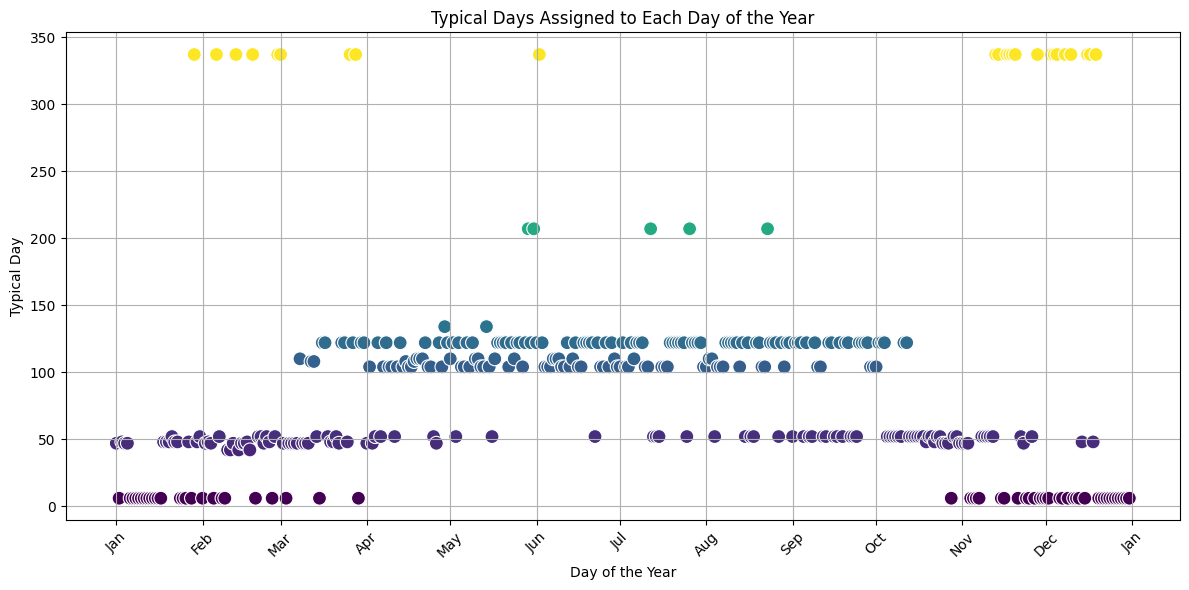

None

In [ ]:
# Plotting of the typical days through the year
# Convert the index to datetime for better plotting
cluster_matrix.index = pd.to_datetime(cluster_matrix.index, format='%j')  # %j is the day of the year
# Create a new DataFrame for plotting
td_plot = cluster_matrix.reset_index()
td_plot.rename(columns={'index1': 'DayOfYear'}, inplace=True)
td_plot['DayOfYear'] = pd.to_datetime(td_plot['DayOfYear'], format='%j')
# Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(data=td_plot, x='DayOfYear', y='TypicalDay', hue='TypicalDay', palette='viridis', s=100, legend=None)
plt.title('Typical Days Assigned to Each Day of the Year')
plt.xlabel('Day of the Year')
plt.ylabel('Typical Day')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.grid(True)
plt.tight_layout()
display(plt.show())

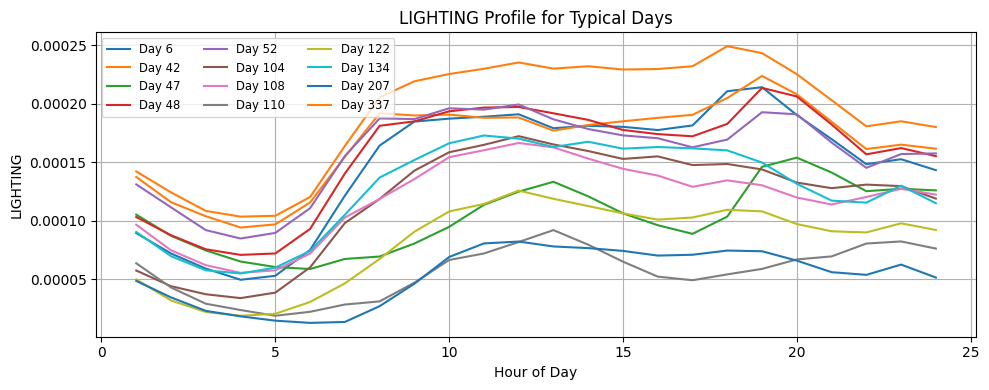

None

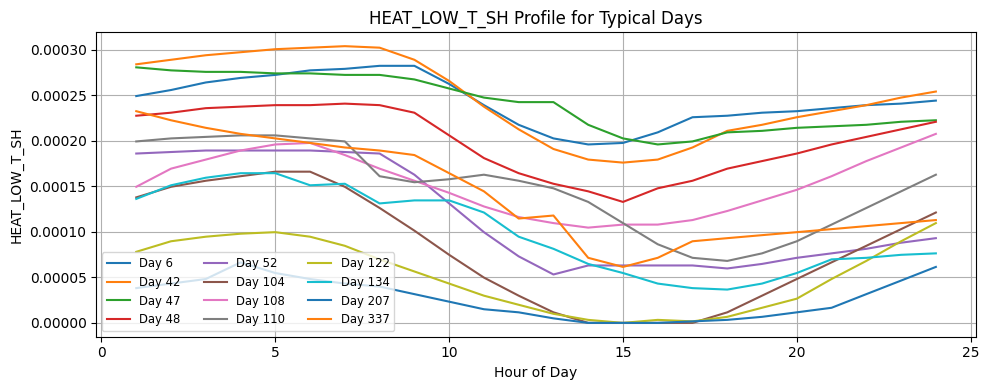

None

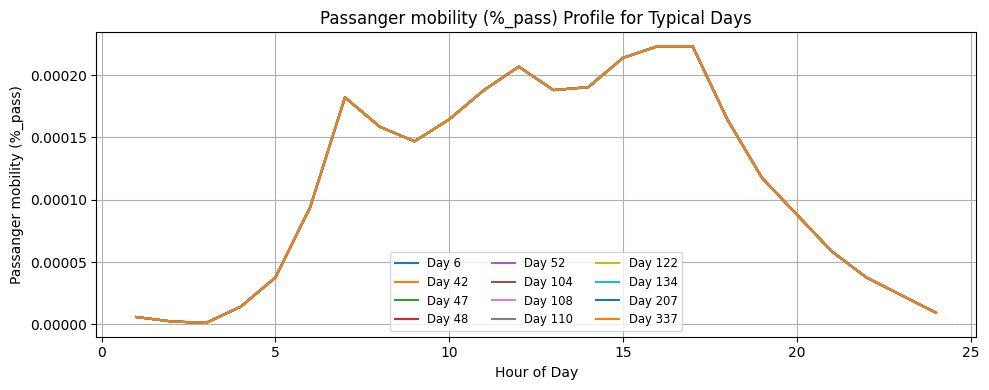

None

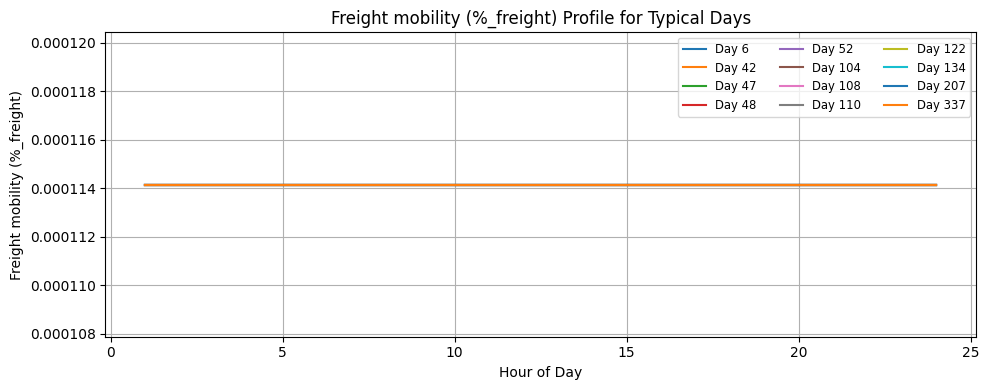

None

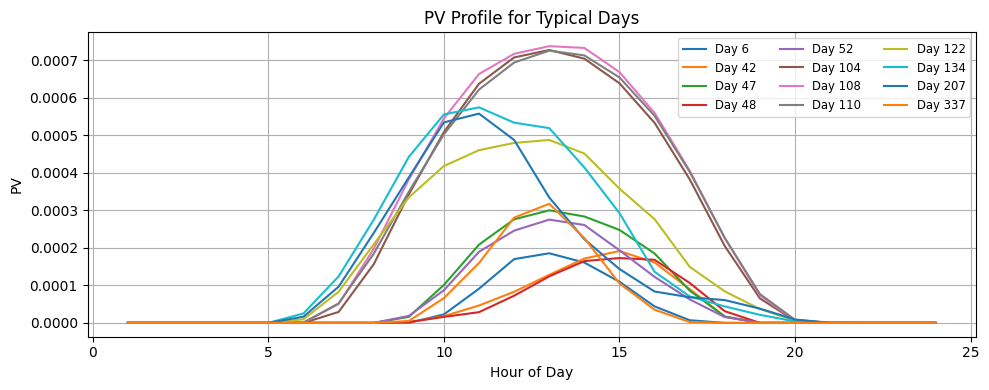

None

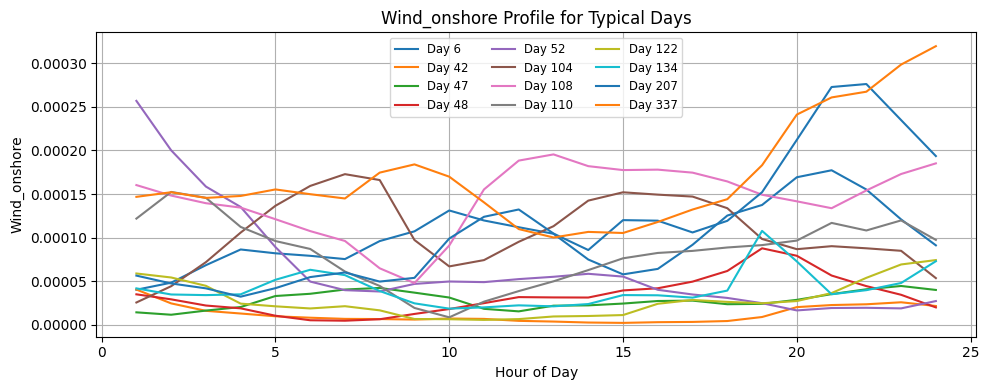

None

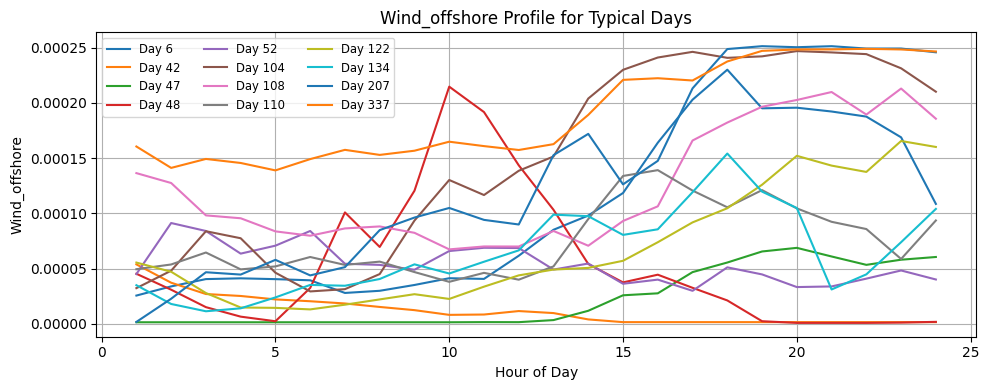

None

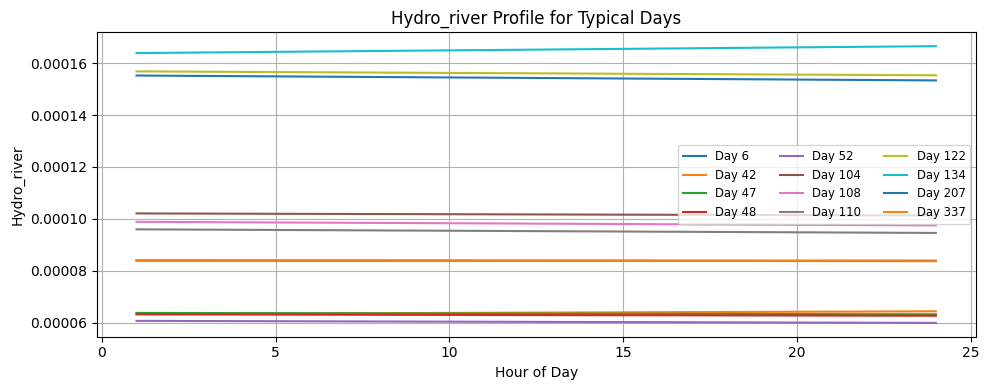

None

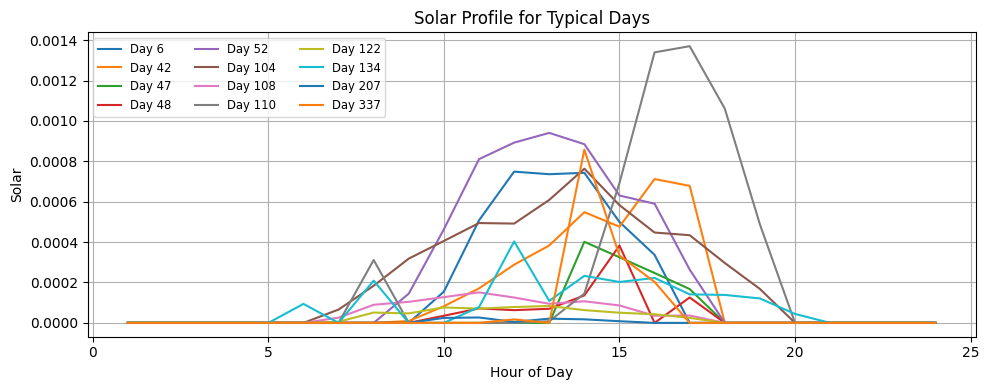

None

In [ ]:
# Plotting the differents times series for each features
# Get the list of representative (cluster-centre) days
typical_days = sorted(cluster_matrix['TypicalDay'].unique())

# Features available in the normalized daily pivot (e.g., LIGHTING, HEAT_LOW_T_SH)
features = n_daily_ts.columns.levels[0]

# For each feature, overlay all typical-day profiles
for var in features:
    plt.figure(figsize=(10, 4))
    for day in typical_days:
        # Extract hour 1–24 profile for this feature on the centre day
        profile = n_daily_ts.loc[day][var]
        plt.plot(profile.index, profile.values, label=f'Day {day}')
    plt.title(f'{var} Profile for Typical Days')
    plt.xlabel('Hour of Day')
    plt.ylabel(var)
    plt.grid(True)
    plt.legend(ncol=3, fontsize='small')
    plt.tight_layout()
    display(plt.show())